# Convolutional MNIST Classifier

In [162]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from matplotlib import pyplot

%matplotlib inline

In [5]:
mnist = input_data.read_data_sets('MNIST_data', one_hot = True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Interactive Sessions
Interactive sessions allows one to interleave operations and building up the computational graph.

In [69]:
sess = tf.InteractiveSession()

### Create Placeholders
784 is the dimension of a single flatten 28 x 28 pixel MNIST image. Target output is 10-dimensional one-hot vector.

In [70]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])

### Create Variables (and initialize to zero)
W is 784 x 10 and
b is 10 x 1

In [98]:
W = tf.Variable(tf.random_normal(shape=(784, 10)))
b = tf.Variable(tf.zeros([1,10]))
print(W)
print(b)

sess.run(tf.global_variables_initializer())

<tf.Variable 'Variable_7:0' shape=(784, 10) dtype=float32_ref>
<tf.Variable 'Variable_8:0' shape=(1, 10) dtype=float32_ref>


In [99]:
z = tf.matmul(x, W) + b
print(z)

Tensor("add_2:0", shape=(?, 10), dtype=float32)


### Specify Loss Function

In [100]:
cross_entropy = (tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=z) )

In [101]:
optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)

In [108]:
for _ in range(15000):
    x_batch, y_batch = mnist.train.next_batch(100)
    optimizer.run(feed_dict={x: x_batch, y: y_batch})
    # sess.run(optimizer, feed_dict={x: x_batch, y: y_batch}) also works

In [109]:
correct_prediction = tf.equal(tf.argmax(z, axis = 1), tf.argmax(y, axis = 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))

0.9077


In [116]:
sess.run(W[1])

array([ 0.44051263,  0.01693079, -2.36604524,  2.419554  , -0.01391761,
        2.20235085, -0.62979233,  1.94679809, -0.67295057, -1.44783616], dtype=float32)

# Convolutional Implmentation

Note that variables should be initialized randomly (break symmetry) and slightly positive (avoid dead neurons from ReLU).

Note on ksize: [1,2,2,1] because we want a window size 2x2 for width x height of image. The first "1" is the dimension that represents the number of training examples and the last "1" represents the number of channels.

In [147]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(input=x, filter=W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(value=x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

### Convolution Layer 1

Reshape input matrix x to shape (m,28,28,1)

In [150]:
x_image = tf.reshape(x, [-1, 28, 28, 1])

In [148]:
W_conv1 = weight_variable([5,5,1,32])
b_conv1 = bias_variable([1, 32])

In [151]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

### Convolution Layer 2

In [153]:
W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([1,64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

### Densely Connected Layers
Verify that the image size is now reduced to 7x7 (64 features). Now add a fully-connected layer with 1024 neurons

In [155]:
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1, 1024])

h_pool2_flat = tf.reshape(h_pool2, [-1,7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

### Implement Dropout (optional)

In [156]:
h_fc1_drop = h_fc1

### Readout Layer 

In [157]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([1,10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Train and Evaluate

In [161]:
cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = y_conv))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cross_entropy_loss)

correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_conv, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# To log of every 100th iteration
cost_log = []
train_acc_log = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
        x_batch, y_batch = mnist.train.next_batch(50)
        if i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict = {x: x_batch, y: y_batch})
            train_acc_log.append(train_accuracy)
            
        _, cost = sess.run([optimizer, cross_entropy_loss], feed_dict={x: x_batch, y: y_batch})
        
        if i % 100 == 0:
            cost_log.append(cost)
            print('Iteration %d  cost: %f' % (i, cost))
    
    print('Final Test Acc: %g' % accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))

Iteration 0  cost: 5.367635
Iteration 100  cost: 0.068747
Iteration 200  cost: 0.123142
Iteration 300  cost: 0.259237
Iteration 400  cost: 0.166538
Iteration 500  cost: 0.078250
Iteration 600  cost: 0.051075
Iteration 700  cost: 0.079471
Iteration 800  cost: 0.006283
Iteration 900  cost: 0.032970
Iteration 1000  cost: 0.078704
Iteration 1100  cost: 0.095621
Iteration 1200  cost: 0.037011
Iteration 1300  cost: 0.048620
Iteration 1400  cost: 0.083749
Iteration 1500  cost: 0.022697
Iteration 1600  cost: 0.064767
Iteration 1700  cost: 0.073156
Iteration 1800  cost: 0.015292
Iteration 1900  cost: 0.006467
Iteration 2000  cost: 0.168783
Iteration 2100  cost: 0.000995
Iteration 2200  cost: 0.005052
Iteration 2300  cost: 0.007801
Iteration 2400  cost: 0.007481
Iteration 2500  cost: 0.008946
Iteration 2600  cost: 0.003225
Iteration 2700  cost: 0.117695
Iteration 2800  cost: 0.003592
Iteration 2900  cost: 0.002568
Iteration 3000  cost: 0.104016
Iteration 3100  cost: 0.150768
Iteration 3200  cost

In [167]:
?pyplot.plot

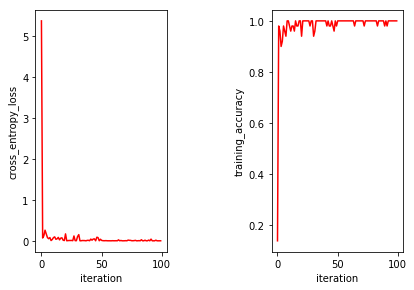

In [177]:
pyplot.subplot(1, 2, 1)
pyplot.plot(cost_log, 'r')
ax = pyplot.gca()
ax.set_xlabel('iteration')
ax.set_ylabel('cross_entropy_loss')

pyplot.subplot(1,2,2)
pyplot.plot(train_acc_log, 'r')
ax = pyplot.gca()
ax.set_xlabel('iteration')
ax.set_ylabel('training_accuracy')

pyplot.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.80)